# Cross-Validation

Learning Objectives:
* Students will partition data into training, validation, and testing sets, and understand the rationale for such partitioning.
* Students will learn of and practice cross-validation for hyperparameter tuning.
* Students will increase experiential understanding of bias-variance tradeoffs and under/overfitting through the visualization of training/validation curves.

Readings before class:
* Jason Brownlee's [What is the Difference Between Test and Validation Datasets?](https://machinelearningmastery.com/difference-test-validation-datasets/)
* Jake VanderPlas's [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/index.html) section on [Hyperparameters and Model Validation](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html)

Before class:
* Read the readings listed above, study the notebook below, and apply cross-validation to the "TO-DO" exercise below.

In class:
* We will complete the section marked "In Class" together.

Homework after class:
* Complete the section labeled "Homework" below before the next class when it will be collected.


In [1]:
# Imports

import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.datasets import load_iris, make_classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, validation_curve, GridSearchCV
  # Note that all imports from model_selection but train_test_split have moved there since VanderPlas' text was published.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# Set random seed for reproducibility
random.seed(0)
np.random.seed(0)

# Training, Validation, and Testing

Thus far in the course, for simplicity (and mirroring common practice), we have split data into two training and testing sets.  However, like many, we haven't always used the testing set as it truly should be used, as a final unbiased assessment of the expected performance of our model.  We have instead made use of the testing set to tune hyperparameters (e.g. finding the best $k$ for $k$-nearest-neighbor).  This is the proper role of a _validation set_.  We've been occasionally using our testing set as a validation set.

Why shouldn't we?  The simple answer is that the use of the testing set to tune hyperparameters of our models can result in a subtle bias where we may, through hyperparameter tuning, learn something of our testing set and no longer get an unbiased assessment of expected performance.

(Tangent on the **difference between _parameters_ and _hyperparameters_**:  To the Computer Scientist, a _parameter_ is a value passed to an object or function.  To the Data Scientist, a _parameter_ is an automatically learned value of the model, such as linear regression intercept and coefficients or neural network weights, whereas a _hyperparameter_ is a manually set value that is passed to the model to customize learning of the model _parameters_.  As a result of the naming overlap, we will often use _parameter_ and _hyperparameter_ interchangeably. After all, a Python model hyperparameter in Data Science terminology is also a Python object constructor or function parameter in Computer Science programming language terminology.)

Let us reconsider Jason Brownlee's list of definitions for training, validating, and testing dataset as we prepare to shift our thinking on them:

* **Training Dataset**: The sample of data used to fit the model.
* **Validation Dataset**: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
* **Test Dataset**: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

What this practically means is that we should
* split our data into 3 partitions ("train"/"val"/"test"),
* iteratively build our models with the "train" data for different hyperparameters, seeking to optimize error scores observed when applying the "train" model for each hyperparameter choice to the "val" data,
* rebuild our best "train" model using its best hyperparameters, and
* perform a final evaluation of this model with the "test" data.

Note that the "test" data is ideally used _only once_ for final evaluation.

## Revisiting the Iris Example

So how to we get three sets when train_test_split only divides into two sets of X's and y's?  We apply the split twice.  Suppose we use the typical 70% / 15% / 15% split for "train" / "val" / "test", respectively:


In [2]:
# Load iris data and split into 70% train, 15% val, 15% test.
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)  # 70% for "train", 30% for "val" and "test" combined
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=1)  # 50% * 30% = 15% each for "val" and "test"
print('For train, val, and test, our partition sizes are {}, {}, and {}, respectively.'.format(len(y_train), len(y_val), len(y_test)))

For train, val, and test, our partition sizes are 105, 22, and 23, respectively.


Now, we'll use the validation set to help us tune $k$ for $k$-Nearest Neighbor classification.

In [3]:
def get_accuracy(k):  # get validation accuracy
    # Build the k-NN classifier
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    # Compute predictions
    return accuracy_score(y_val, model.predict(X_val))  # <-- NOTE: We're using "val" sets here now!

ks = list(range(1, 21))
accuracies = [get_accuracy(k) for k in ks]
best_idx = np.argmax(accuracies)
best_k, best_accuracy = ks[best_idx], accuracies[best_idx]
print('For the iris data, k-NN has the best validation accuracy of {} for k = {}.'.format(best_accuracy, best_k))

For the iris data, k-NN has the best validation accuracy of 1.0 for k = 7.


Finally, we test our final model against the "test" data.

In [4]:
# Build the k-NN classifier
model = KNeighborsClassifier(n_neighbors=best_k)  # build our best model with the hyperparameter found with the validation set
model.fit(X_train, y_train)
# Compute predictions
print('Test accuracy:', accuracy_score(y_test, model.predict(X_test)))  # <-- NOTE: We're using "test" sets here now just once.

Test accuracy: 0.9565217391304348


Note that our test accuracy is lower.  This isn't surprising.  In fact, this is the _point_.  If we tune hyperparameters to our validation set, we expect to have optimized our accuracy for validation.  Holding out a test set for final evaluation means we get an _unbiased_ assessment of our model's quality.  The validation set isn't a true test of how our model will perform on unseen data because we see our performance with the validation set again and again and we bias our model hyperparameters consciously or unconsciously to get a best fit to the validation set.

## $k$-Fold Cross-Validation

There are other techniques for validation to consider.  Suppose, a Jake VanderPlas illustrates in this figure, that we split the data into five equal portions and have each fifth serve as the validation set in each of 5 model-building and validation iterations:

<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-5-fold-CV.png" alt="5-fold cross-validation" title="5-fold cross-validation" width="600" />

This is what is known as 5-fold cross-validation.  We illustrate this approach by repartitioning our data into only "train" and "test", allowing our sklearn Python tools to perform the partitioning and testing for us.  Note the different Python code structure we use to find our best $k$.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=1)  # 85% for "train", 15% for "test"

best_k = 1
best_accuracy = 0
for k in ks:
    model = KNeighborsClassifier(n_neighbors=k)
    avg_accuracy = np.mean(cross_val_score(model, X_train, y_train, cv=5))
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_k = k
print('For the iris data, k-NN has the best 5-fold cross-validation accuracy of {} for k = {}.'.format(best_accuracy, best_k))

For the iris data, k-NN has the best 5-fold cross-validation accuracy of 0.976 for k = 8.


For small datasets like Iris, one can take this concept to the extreme, performing $n$-fold cross-validation for a dataset of size $n$.  This means that we build $n$ models from $n$ - 1 training examples and validate with a _single example_.  This computationally intensive approach, only suitable for small datasets, is called "leave-one-out" and looks like this:

In [6]:
best_k = 1
best_accuracy = 0
for k in ks:
    model = KNeighborsClassifier(n_neighbors=k)
    avg_accuracy = np.mean(cross_val_score(model, X_train, y_train, cv=LeaveOneOut()))  # Note that LeaveOneOut now takes no arguments.
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_k = k
print('For the iris data, k-NN has the best leave-one-out cross-validation accuracy of {} for k = {}.'.format(best_accuracy, best_k))

For the iris data, k-NN has the best leave-one-out cross-validation accuracy of 0.9763779527559056 for k = 10.


This last leave-one-out approach indicates highest accuracy among our three attempts at hyperparameter tuning, but also notice that it is the approach that gets to use the _largest fraction of the non-test data_ for model building.  As it turns out, our choice of k is not so critical for this very small dataset:

In [7]:
# Build the k-NN classifier
model = KNeighborsClassifier(n_neighbors=best_k)  # build our best model with the hyperparameter found with leave-one-out validation.
model.fit(X_train, y_train)
# Compute predictions
print('Test accuracy:', accuracy_score(y_test, model.predict(X_test)))

Test accuracy: 0.9565217391304348


## TO-DO: Pre-class Exercise

Split off 15% of the dataset below as a test dataset.  Use the remainder with some form of cross-validation in order to tune hyperparameters for some of the classifiers you've come to understand in this course.  How high an accuracy can you achieve with cross-validation?

Once you've settled on a best model with best hyperparameters, compute accuracy _only once_ with the test dataset.

In [8]:
# Generate classification dataset
X, y = make_classification(flip_y=.2, random_state=26)



RandomForestClassifier(n_estimators=10, max_depth=3, random_state=0)
Test accuracy: 0.8666666666666667


## In Class

In class, we will replicate Jake VanderPlas' approach to polynomial regression to demonstrate underfitting, overfitting, and hyperparameter grid search, but we will _skip_ the learning curve portion.

Changes since the text was published:  Not only have many of the classes used here moved to the sklearn.model_selection package, but there is a syntactic difference as well.  Whereever you see pipeline parameters "'polynomialfeatures__degree', degree,", change the code to "param_name='polynomialfeatures__degree', param_range=degree,".  Also, omit the "hold=True" parameter in the final grid search fit.

First, we create the pipeline for polynomial regression.  This creates a process where features are processed automatically into polynomial terms according to the given degree.  (It's much easier this way, isn't it!  But it is limited to polynomials, and it was important to understand earlier how to do arbitrary nonlinear regression with linear regression.)  After that processing in the pipeline, these preprocessed polynomial features and all other keyword arguments (kwargs) are passed along to the LinearRegression model for modeling.

In [9]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Next, we'll create a dataset that's not polynomial, but that we'll seek to fit with successive degree polynomials of degree 2, 4, 8, and 16.

<class 'numpy.ndarray'>


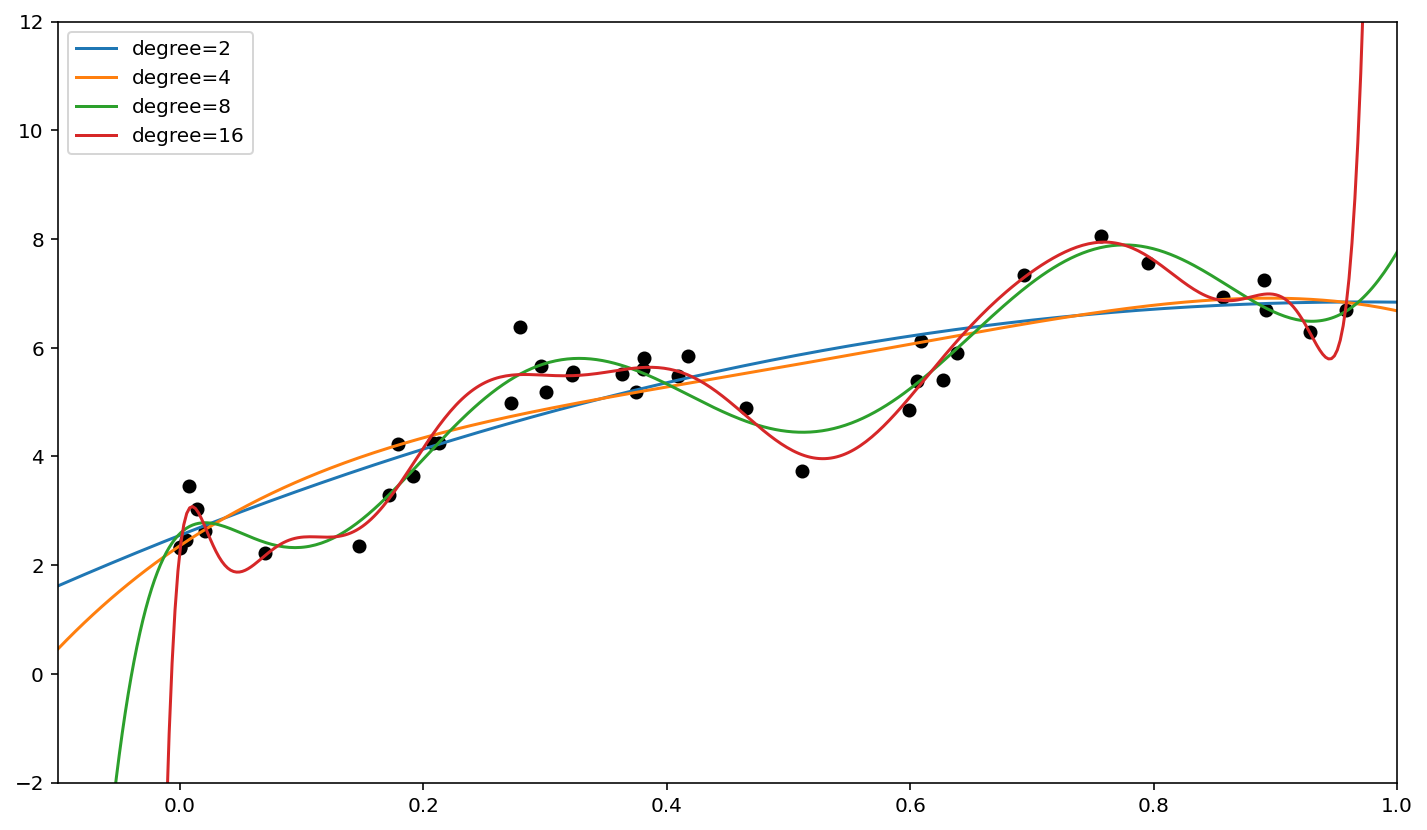

In [10]:
def make_data(N, err=.5, rseed=0):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    print(type(X))
    y = math.pi - np.sin(15 * X) + 5 * X + err * rng.randn(N, 1)
    return X, y

X, y = make_data(40)

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [2, 4, 8, 16]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

Visualize the validation curve with 7-fold cross-validation.

Pick the best degree according to the validation curve and plot it over the scatterplot of the data.

Next we'll see what happens with the validation curves if we have 5 times as much data, just like in the text:

Compare the new validation curve to the old for this larger dataset.

With more data, we don't seem to suffer from overfitting as easily.  Still, we prefer the simplest degree polynomial that has a good score.  Find the best polynomial degree with this larger data set and plot it against the data scatterplot.

We'll turn our attention now to grid search cross validation that will allow us to automatically optimize hyperparameters.  Perform the same grid search process you see in the VanderPlas text.

## Homework


**Exercise 1:** Complete the in-class exercises if you haven't already.

**Exercise 2:**  Compute a model with $R^2$ score greater than 0.8 with the dirty DataFrame loaded below using the data cleaning methods of previous classes and cross-validation with a suitable regression method.  Only test your $R^2$ with **30% testing data** once at the end of your code.


In [17]:
df = pd.read_csv('http://cs.gettysburg.edu/~tneller/ds256/data/hw26/hw26.csv')


(end of homework)